# TP 1 et 2: Linear Discriminant Analysis (LDA)

Auteurs: S. Zhang, L. Mousset (2023) & P. Richard (2024) (pablo.richard@ens.fr)

Ce TP couvre **2 séances**. Le but est de classifier des simulations du milieu interstellaire. Nous allons réaliser des analyses discriminantes linéaires (LDA) en utilisant différents estimateurs statistiques :
1. la moyenne empirique
2. la matrice d'autocovariance empirique
3. le spectre de puissance

On comparera ensuite les performances de ces différentes méthodes.

On pourra se référer à cette page Wikipédia sur la LDA: https://fr.wikipedia.org/wiki/Analyse_discriminante_lin%C3%A9aire

**Evaluation :**
Ce notebook sera évalué. Il comptera pour 15% de la note finale. Le notebook devra être rendu avant le **05 Juin 2024**.

Critères d'évaluation : 
- code qui tourne (sans retourner d'erreur) et est-ce que le code répond à la question.
- clareté : commentaires, docstrings pour les fonctions, axes, titre et légende sur les plots...
- effort de recherche et mise en application des concepts du cours.

In [1]:
# Pour les plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Calcul scientifique
import numpy as np
import scipy
from scipy.fft import fft2

# Librairie maison dans le dossier avec les notebooks
from utils import bin_to_float, convert_cls2fls, save_obj, load_obj

# Librairie Scikit Learn
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

## Charger les données

On va utiliser des cartes (256x256) pixels, ce sont des simulations du milieu interstellaire. Plusieurs jeux de simulations ont été réalisés en variant deux paramètres physiques : le champ magnétique et la température. En fonction des valeurs de ces deux paramètres, on a pu définir 9 classes. 

On lit les données qui sont stockées dans le dossier `data/`. Les cartes sont séparées en deux catégories:
- Train : les données d'apprentissage (= d'entrainement)
- Test : les données de validation réservées aux tests

Chaque catégorie est séparée en 9 classes. Pour la catégorie Train, chaque classe contient 20 images alors que pour la catégorie Test, chaque classe contient 15 images.

Les images sont stockées en format binaire dans des fichiers `.dat`. Ces fichiers sont des tableaux 1D (256x256x8) où le 8 correspond aux 8 bytes.

In [2]:
# Paramètres
NbClasses = 9
SizeMaps = 256
TrainBaseFolder = './data/LearnEchantillons'
NbMapsTrain = 20
TestBaseFolder = './data/ClassEchantillons'
NbMapsTest = 15

**0.1 TODO :** Ecrire une fonction qui charge les données. Elle doit retourner un dictionnaire de numpy arrays (#Images, 256, 256), chaque élément du dictionnaire correspondant à une classe.

In [3]:
# Lecture des échantillons
def read_imgs(BaseFolder: str, NbClasses: int, NbMaps: int, SizeMaps: int) -> dict:
    imgs_cls = {}  # Initialisation du dictionnaire
    for i in range(NbClasses):  # Boucle sur les 9 classes
        imgs = np.zeros((NbMaps, SizeMaps, SizeMaps))
        # %%%%% TODO %%%%%
        for j in range(NbMaps):  # Boucle sur les images
            ### Load the image j as a 1D array
            img = np.fromfile(BaseFolder + f'/{i+1}/{j+1}.dat')  # [SizeMaps x SizeMaps]
            ### Reshape it as a 2D array
            imgs[j, :, :] = np.reshape(img, newshape=(SizeMaps, SizeMaps))
        # %%%%% end TODO %%%%%
        
        imgs_cls[i] = imgs  # On met les images de la classe i dans le dictionnaire
        
    return imgs_cls

**0.2 TODO :** En appliquant la fonction `read_imgs()`, contruire 2 dictionnaires avec les données Test et les données Train

In [4]:
# %%%%% TODO %%%%%
ImgsTrain = read_imgs(TrainBaseFolder, NbClasses, NbMapsTrain, SizeMaps)
ImgsTest = read_imgs(TestBaseFolder, NbClasses, NbMapsTest, SizeMaps)
# %%%%% end TODO %%%%%

**0.3 TODO :**  Sauver chaque dictionnaire sous la forme d'un fichier pickles. On utilisera la fonction `save_obj()` de `utils.py()`.

In [5]:
# %%%%% TODO %%%%%
save_obj(ImgsTrain, 'ImgsTrain')
save_obj(ImgsTest, 'ImgsTest')
# %%%%% end TODO %%%%%

Remarque: Ces fichiers peuvent être chargés avec la fonction `load_obj`. Cela sera utile pour les prochains TPs.

In [6]:
ImgsTrain = load_obj('ImgsTrain')
ImgsTest = load_obj('ImgsTest')

**0.4 TODO :** Afficher des images de différentes classes. Peut-on différencier les classes à l'oeil nu ?

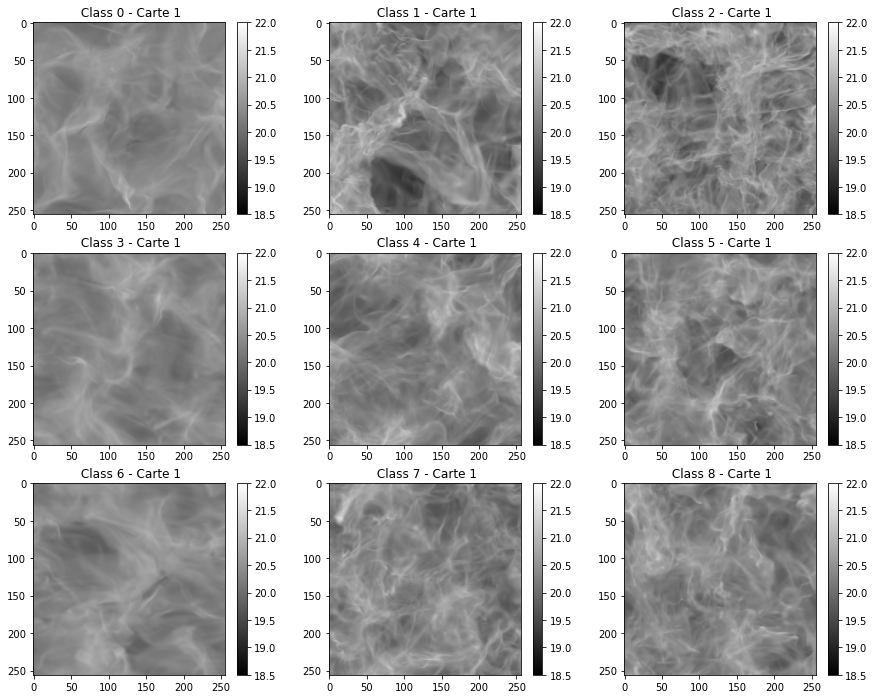

In [7]:
# Plot
j = 1 # Indice de la carte
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.ravel()
for i in range(9):  # Indice de la class
    im = axs[i].imshow(ImgsTrain[i][j,:,:], vmin=18.5, vmax=22, cmap='gray')
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title(f' Class {i} - Carte {j}')
plt.show()

**0.5 TODO :** Quelles conditions aux limites vérifient ces images ? On pourra faire un plot d'une image en utilisant la fonction `np.roll()` (https://stackoverflow.com/questions/19878280/efficient-way-to-shift-2d-matrices-in-both-directions).

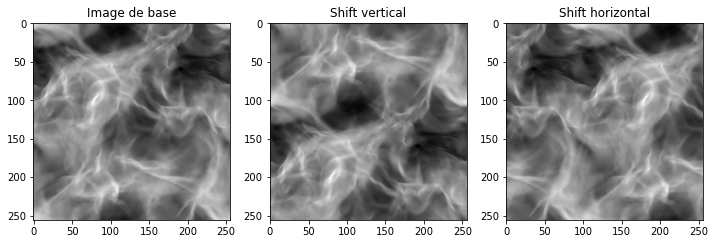

In [8]:
# %%%%% TODO %%%%%
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
ax0.imshow(ImgsTrain[0][0,:,:], cmap='gray')
ax0.set_title('Image de base')

ax1.imshow(np.roll(ImgsTrain[0][0,:,:], shift=100, axis=0), cmap='gray')
ax1.set_title('Shift vertical')

ax2.imshow(np.roll(ImgsTrain[0][0,:,:], shift=100, axis=1), cmap='gray')
ax2.set_title('Shift horizontal')
plt.show()
# %%%%% end TODO %%%%%

## Etape 1: Linear Discriminant Analysis (LDA) avec la moyenne empirique

**1.1 TODO :** Compléter la fonction suivante qui doit retourner un dictionnaire contenant la moyenne de chaque image.

In [9]:
def compute_features_mean(Imgs: dict, NbClasses: int, NbMaps: int) -> dict:
    mu_cls = {}
    # %%%%% TODO %%%%%
    for i in range(NbClasses):  # Boucle sur les classes
        mu_cls[i] = np.zeros((NbMaps))
        for j in range(NbMaps):  # Boucles sur les images
            mu_cls[i][j] = np.mean(Imgs[i][j, :, :])  # Calcule la moyenne
    # %%%%% end TODO %%%%% 
    return mu_cls

**1.2 TODO :** Appliquer la fonction précédente pour construire deux dictionnaires associés aux cartes Train et Test. Afficher les valeurs des moyennes et les tracer sur un graphe. A votre avis, la moyenne est-elle un bon marqueur statistique pour classifier ces images ?

In [10]:
# %%%%% TODO %%%%%
MeanTrain = compute_features_mean(ImgsTrain, NbClasses, NbMapsTrain)
MeanTest = compute_features_mean(ImgsTest, NbClasses, NbMapsTest)
# %%%%% end TODO %%%%%

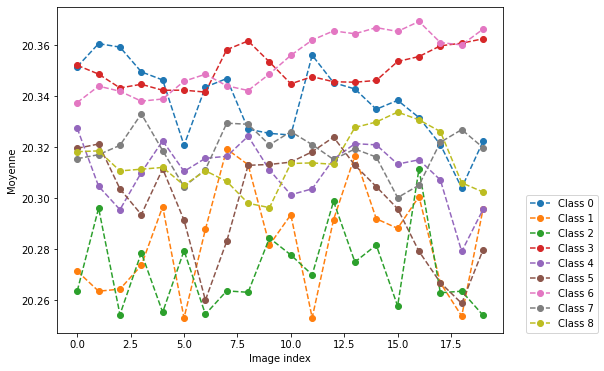

In [11]:
# %%%%% TODO %%%%%
plt.figure(figsize=(8, 6))
for i in range(NbClasses):
    plt.plot(MeanTrain[i], 'o--', label=f'Class {i}')
    plt.ylabel('Moyenne')
    plt.xlabel('Image index')
plt.legend(loc=(1.05,0))
plt.show()
# %%%%% end TODO %%%%%

**1.3 TODO :** Compléter la fonction suivante qui réalise la classification par LDA. **Cette fonction sera réutilisée dans les TP suivants.** En plus de la LDA, elle devra retourner les matrices de confusion et les test d'accuracy sur les données Train et Test. 

Nous allons utiliser la librairie scikit-learn. Voir éventuellement : https://scikit-learn.org/0.24/auto_examples/classification/plot_lda_qda.html?highlight=lda

Ne pas hésiter à prendre des fonctions toutes faites pour le calcul de confusion et d'accuracy.

In [12]:
def classify_by_LDA(dataTrain: dict, dataTest: dict) -> dict:
    
    # Construit les features et les labels des données Train et Test pour l'apprentissage supervisé via la fonction convert_cls2fls de utils.py().
    featuresTrain, labelsTrain = convert_cls2fls(dataTrain, NbClasses, NbMapsTrain)
    featuresTest, labelsTest = convert_cls2fls(dataTest, NbClasses, NbMapsTest)
    
    # %%%%% TODO %%%%%
    clf = LinearDiscriminantAnalysis(store_covariance=True)  # Instancie l'objet LDA
    
    # Donneés Train
    clf.fit(featuresTrain, labelsTrain) # Fit
    predictTrain = clf.predict(featuresTrain)  # Prédiction
    cmatTrain = confusion_matrix(labelsTrain, predictTrain)  # Matrice de confusion
    accuracyTrain = accuracy_score(labelsTrain, predictTrain) # Test d'accuracy
    
    # Données Test
    predictTest = clf.predict(featuresTest)  # Prédiction
    cmatTest = confusion_matrix(labelsTest, predictTest)  # Matrice de confusion
    accuracyTest = accuracy_score(labelsTest, predictTest)  # Test d'accuracy
    # %%%%% end TODO %%%%% 
    
    return {'train_cm': cmatTrain, 'train_acc': accuracyTrain, 'test_cm': cmatTest, 'test_acc': accuracyTest, 'lda': clf}


**1.4 TODO :** Appliquer la fonction `classify_by_LDA()` sur les moyennes et afficher les résultats (matrices de confusion et tests d'accuracy sur les données Train et Test). On pourra s'aider de https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html


 LDA parameters
number of LDA features 1
LDA mean per class [[20.33755556]
 [20.28377497]
 [20.27225352]
 [20.35045192]
 [20.31050266]
 [20.29816768]
 [20.35328375]
 [20.3185303 ]
 [20.31420161]]
LDA prior per class [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]


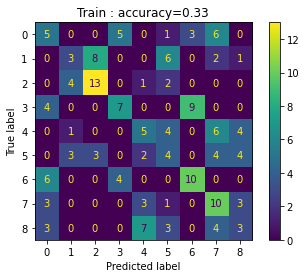

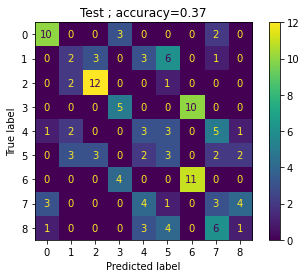

In [13]:
# %%%%% TODO %%%%%
# Appliquer la classification LDA
resultsMean = classify_by_LDA(MeanTrain, MeanTest)

# Print les résultats
print('\n LDA parameters')
print('number of LDA features', resultsMean['lda'].n_features_in_)
print('LDA mean per class', resultsMean['lda'].means_)
print('LDA prior per class', resultsMean['lda'].priors_)

### Train
train_acc = resultsMean['train_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsMean['train_cm'])
disp.plot()
plt.title(f'Train : accuracy={train_acc:.2f}')


### Test
test_acc = resultsMean['test_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsMean['test_cm'])
disp.plot()
plt.title(f'Test ; accuracy={test_acc:.2f}')
plt.show()
# %%%%% end TODO %%%%% 

**1.5 TODO :** Commenter le résultat. La moyenne d'échantillon vous semble t'elle être un bon marqueur pour ces données ?

## Etape 2 : LDA avec la matrice d'autocovariance

Autocovariance : https://fr.wikipedia.org/wiki/Autocovariance  
Autocorrélation : https://fr.wikipedia.org/wiki/Autocorr%C3%A9lation

Soit le vecteur translation $\tau = (\tau_1, \tau_2)$ avec $\tau_1 = 0, 1, ... dn$ et $\tau_2 = -dn, ..., -1, 0, 1, ... dn$. On note $X(u)$ la valeur de l'image $X$ en le pixel $u$. L'autocovariance du processus $X$ (supposé à valeurs réelles) est définie par:

$$\phi(u, \tau) = \mathbb{E} [(X(u)-\mu_u)(X(u-\tau)-\mu_{u-\tau})]$$

**2.1 TODO:** Qu'entend on par $\mathbb E$ dans une telle définition ? Que représentent $\mu_u$ et $\mu_{u-\tau}$ ? À quelle condition l'autocovariance ne dépend que de $\tau$ ? Jusitifer alors l'appelation "matrice d'autocovariance" dans notre cas et donner ses dimensions en fonction du choix de $dn$.

**2.2 TODO :** Proposer un estimateur de la matrice d'autocovariance calculé à partir d'une seule image. Ecrire une fonction qui calcule cet estimateur pour un $dn$ donné. La fonction retournera un dictionnaire de numpy arrays où chaque élément correspond à une classe.

In [14]:
def compute_features_cov(Imgs: dict, dn: int, NbClasses: int, NbMaps: int) -> dict:
    covmat_cls = {}
    for i in range(NbClasses):  # Boucle sur les classes
        # %%%%% TODO %%%%%
        covmat = np.zeros((NbMaps, dn+1, 2*dn+1))
        for j in range(NbMaps):  # Boucle sur les images
            ### Soustraction de la moyenne empirique de l'image
            img0 = Imgs[i][j,:,:] - Imgs[i][j,:,:].mean()  
            ### Calcul de la matrice d'autocovariance (dn+1, 2dn+1)
            # Vecteur translation tau=(tau1, tau2)
            for tau1 in range(dn+1):
                for tau2 in range(-dn,dn+1):
                    # Translation horizontale et verticale
                    img0_shift = np.roll(img0, shift=(tau1, tau2), axis=(0, 1)) 
                    # Calcul de l'autocovariance
                    covmat[j, tau1, tau2] = np.mean(img0*img0_shift)  

        covmat_cls[i] = covmat
        # %%%%% end TODO %%%%%
        
    return covmat_cls

**2.3 TODO :** Pour un $dn$ entre 0 et 8, calculer ces estimateurs de matrices de covariance sur les données Train et Test et réaliser une classification par LDA. Tracer les tests d'accuracy en fonction de $dn$. 

dn=0 -> number of LDA features: 1
dn=1 -> number of LDA features: 6
dn=2 -> number of LDA features: 15
dn=3 -> number of LDA features: 28
dn=4 -> number of LDA features: 45
dn=5 -> number of LDA features: 66
dn=6 -> number of LDA features: 91
dn=7 -> number of LDA features: 120
dn=8 -> number of LDA features: 153


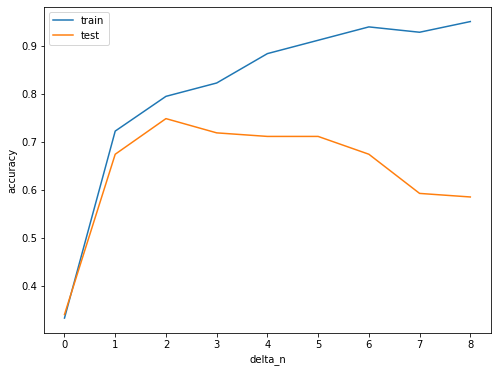

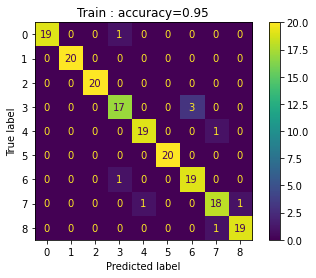

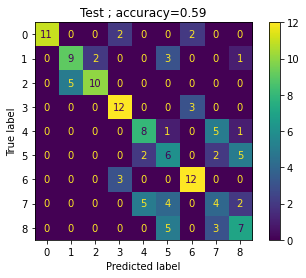

In [15]:
# %%%%% TODO %%%%%
### LDA
delta = []
train_acc = []
test_acc = []
for delta_n in range(9):
    # Calcul des matrices de covariance sur les données Train et Test
    covTrain = compute_features_cov(ImgsTrain, delta_n, NbClasses, NbMapsTrain)
    covTest = compute_features_cov(ImgsTest, delta_n, NbClasses, NbMapsTest)
    # LDA classification
    resultsCov = classify_by_LDA(covTrain, covTest)  
    print('dn={:} -> number of LDA features: {:}'.format(delta_n, resultsCov['lda'].n_features_in_))
    # Sauve les résultas dans des listes pour chaque delta_n
    delta.append(delta_n)
    train_acc.append(resultsCov['train_acc'])
    test_acc.append(resultsCov['test_acc'])  

### Plot
plt.figure(figsize=(8, 6))
plt.plot(delta, train_acc, label='train')
plt.plot(delta, test_acc, label='test')
plt.xlabel('delta_n')
plt.ylabel('accuracy')
plt.legend()

### Print les résultats
### Train
train_acc = resultsCov['train_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsCov['train_cm'])
disp.plot()
plt.title(f'Train : accuracy={train_acc:.2f}')

### Test
test_acc = resultsCov['test_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsCov['test_cm'])
disp.plot()
plt.title(f'Test ; accuracy={test_acc:.2f}')
plt.show()
# %%%%% end TODO %%%%%

**2.4 TODO :** Commenter ces résultats et comparer brièvement à ceux obtenus à l'étape 1.

## Etape 3: LDA en utilisant le spectre de puissance (periodogram)

**3.1 TODO :** Rappeler le lien autocovariance et spectre de puissance.

**3.2 TODO :** Ecrire une fonction qui calcule le spectre de puissance de chaque image pour une fréquence maximale notée $dom$. Elle devra retourner un dictionnaire de numpy arrays, chaque élément du dictionnaire étant associé à une classe. On utilisera `fft2` de la librairie `scipy`. Caluler d'abord le spectre de puissance complet puis le tronquer à la fréquence maximale $dom$.

La fonction pourra plotter le spectre de puissance complet et tronqué pour une image en particulier.

In [16]:
def compute_features_ps(Imgs: dict, dom: int, NbClasses: int, NbMaps: int, SizeMaps: int) -> dict:
    psmat_cls = {}
    for i in range(NbClasses):
        psmat = np.zeros((NbMaps, 2*dom+1, 2*dom+1))
        for j in range(NbMaps):
            # %%%%% TODO %%%%%
            img0 = Imgs[i][j, :, :]
            ### Transformée de Fourier
            #tf = np.fft.fftshift(fft2(img0))
            tf = fft2(img0)
            ### Spectre de puissance
            ps_full = np.abs(tf)**2 / (SizeMaps**2)  # [SizeMaps, SizeMaps]
            ps_full[0,0] /= 1e6 # ad hoc normalization to simplify later plots. This is arbitrary but applied identically for all images so won't change LCA results.
            
            ### Restreint le spectre de puissance entre [-dom, dom]
            for om1 in range(-dom, dom+1):
                for om2 in range(-dom, dom+1):
                    psmat[j, om1, om2] = ps_full[om1, om2]
            
            ### Plot le spectre de puissance complet et tronqué pour une image
            if i == 0 and j == 0:
                fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 5))
                im0 = ax0.imshow(ps_full[:,:], norm=LogNorm())
                ax0.set_title('Full PS')
                plt.colorbar(im0, ax=ax0)
                
                im1 = ax1.imshow(np.fft.fftshift(ps_full[:,:]), norm=LogNorm())
                ax1.set_title('Shifted PS')
                plt.colorbar(im1, ax=ax1)
                
                im2 = ax2.imshow(psmat[j, :,:], norm=LogNorm())
                ax2.set_title('Troncated PS')
                plt.colorbar(im2, ax=ax2)
            
            # %%%%% end TODO %%%%%


        psmat_cls[i] = psmat
        
    return psmat_cls

**3.3 TODO :** Quelle plage de valeurs du métaparamètre $dom$ proposez vous d'étudier et pourquoi ? Pour différents choix de $dom$ que vous proposerez, calculer les spectres de puissance sur les données Train et Test. Puis effectuer une classification par LDA. Tracer les tests d'accuracy en fonction de $dom$.

La dimension des features doit rester petite pour que la LDA soit bien apprise. On restreint donc $dom\leq \sim 10$. Cependant, on teste pour des valeurs plus grandes pour voir l'effet de la dimension. 

dom=0 -> number of LDA features: 1
dom=1 -> number of LDA features: 9
dom=2 -> number of LDA features: 25
dom=4 -> number of LDA features: 81
dom=8 -> number of LDA features: 289
dom=16 -> number of LDA features: 1089
dom=32 -> number of LDA features: 4225


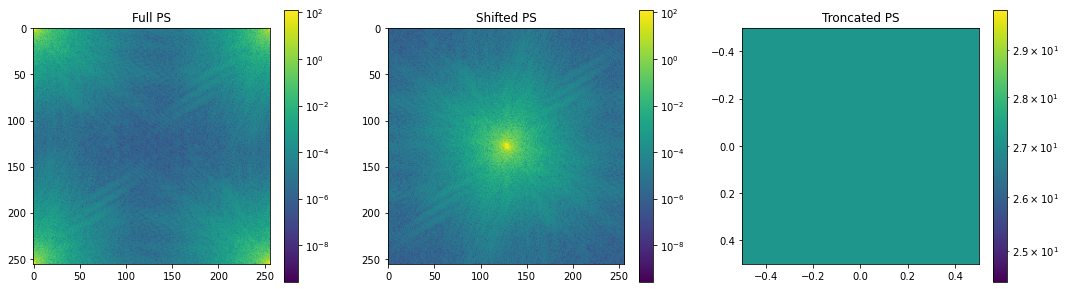

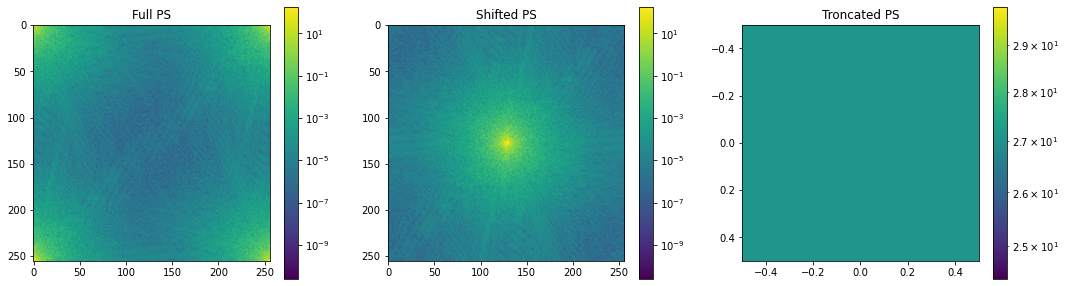

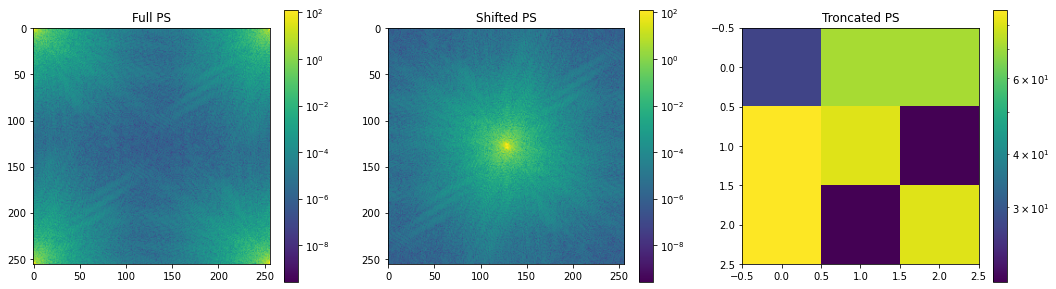

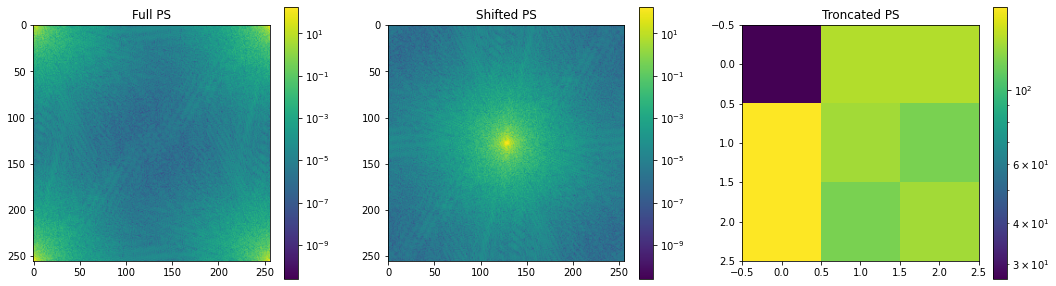

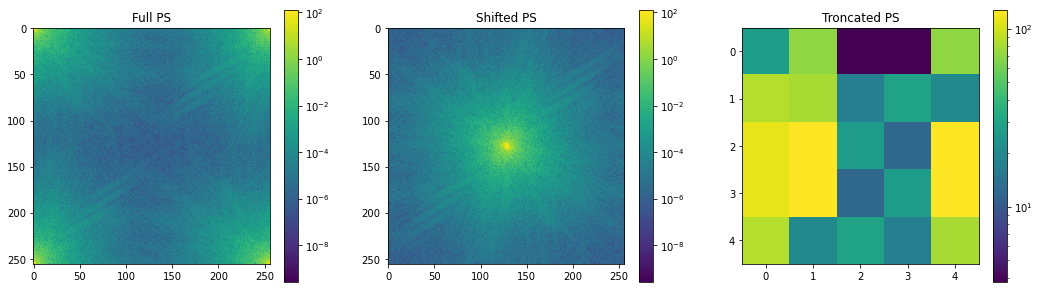

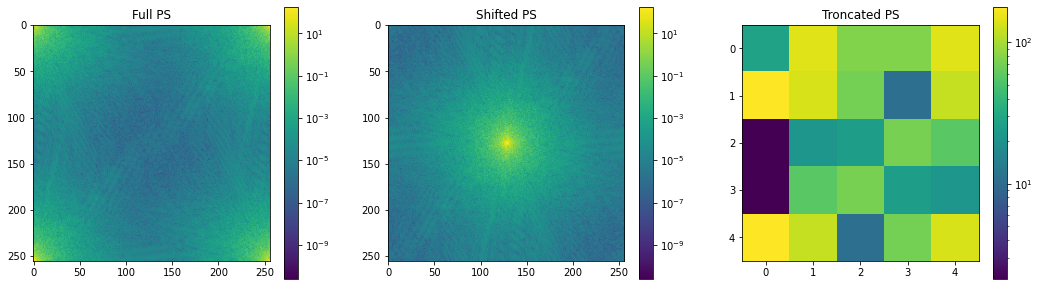

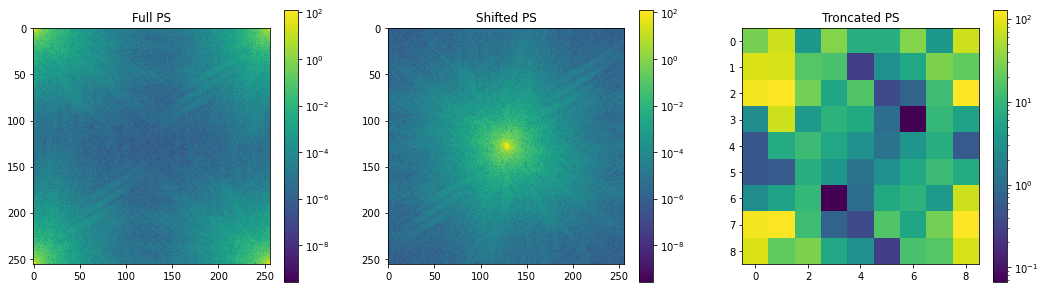

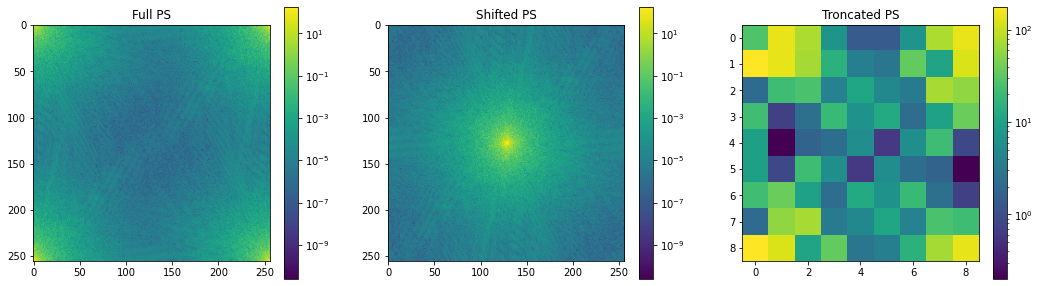

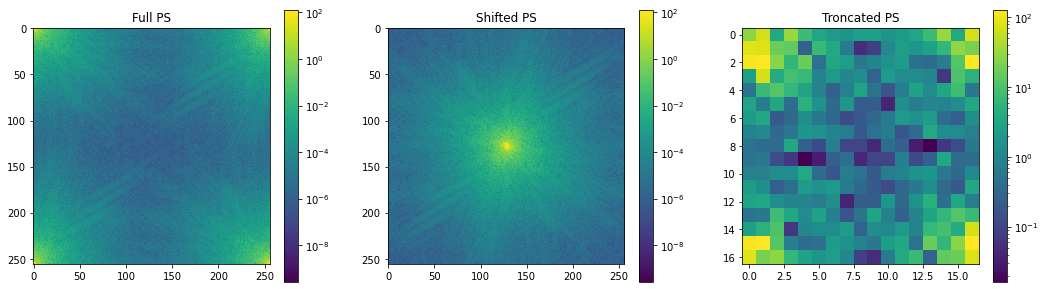

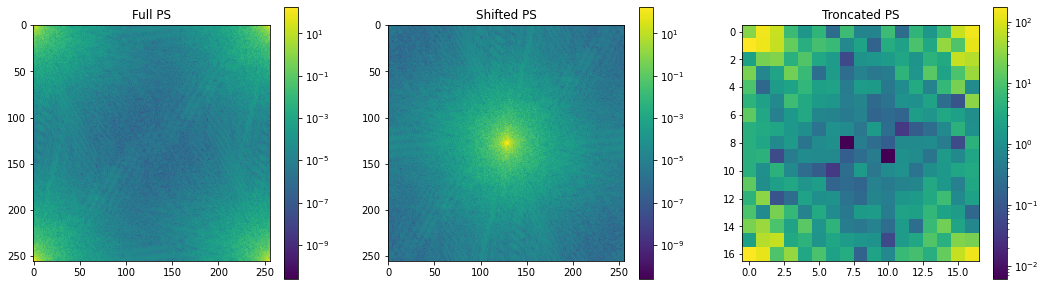

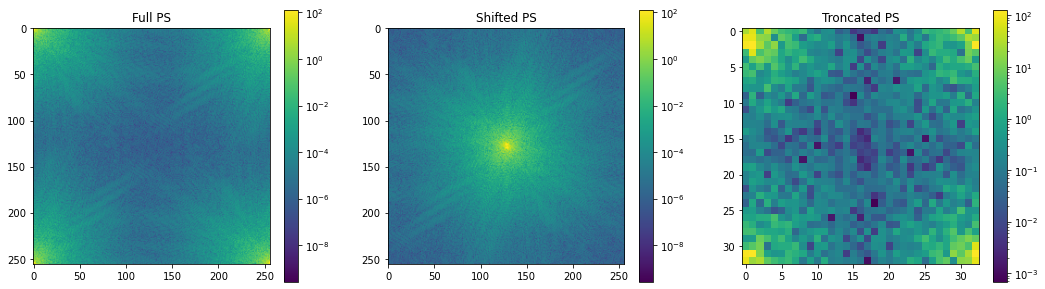

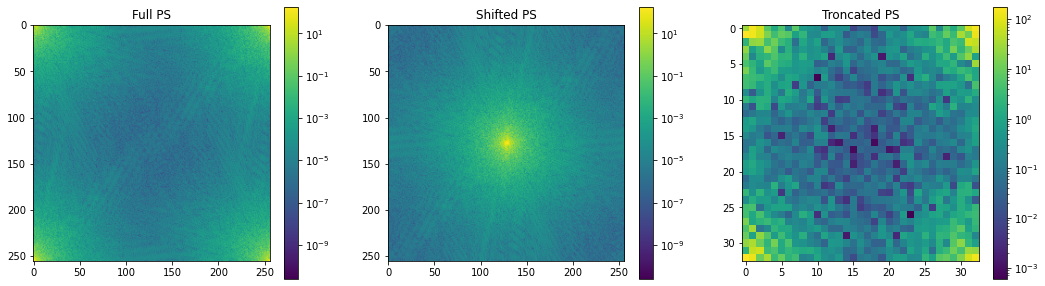

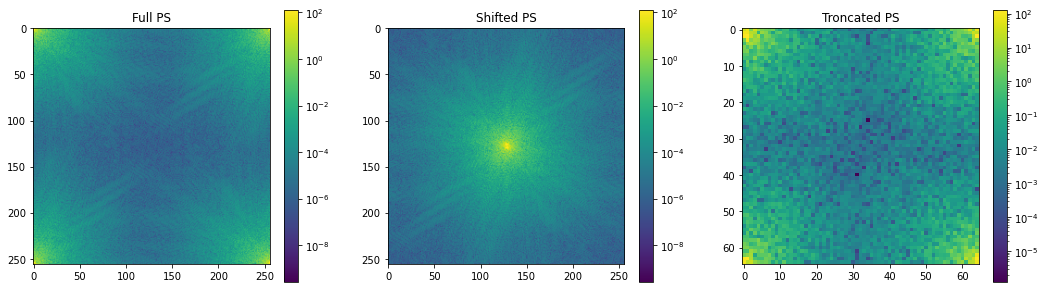

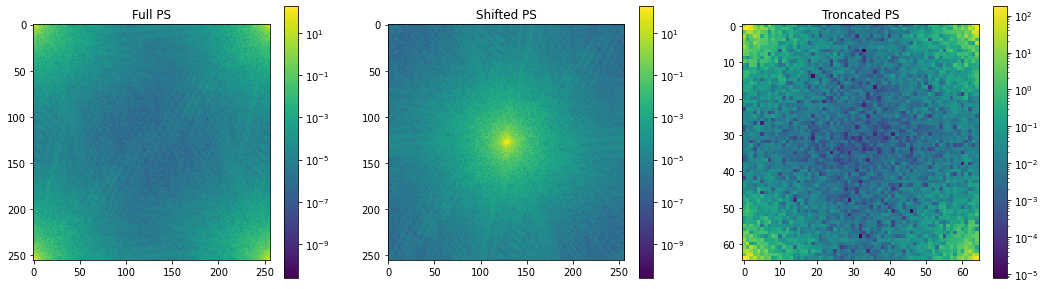

In [17]:
delta = [0, 1, 2, 4, 8, 16, 32]
train_acc = []
test_acc = []
for delta_om in delta:
    # Calcul les spectres de puissance sur les données Train et Test
    psTrain = compute_features_ps(ImgsTrain, delta_om, NbClasses, NbMapsTrain, SizeMaps)
    psTest = compute_features_ps(ImgsTest, delta_om, NbClasses, NbMapsTest, SizeMaps)

    # LDA classification
    resultsPs = classify_by_LDA(psTrain, psTest)
    print('dom={:} -> number of LDA features: {:}'.format(delta_om, resultsPs['lda'].n_features_in_))

    # Sauve les résultats dans des listes pour le plot
    train_acc.append(resultsPs['train_acc'])
    test_acc.append(resultsPs['test_acc'])

Text(0.5, 1.0, 'Test ; accuracy=0.55')

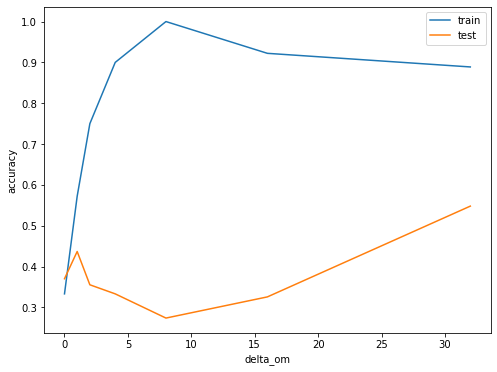

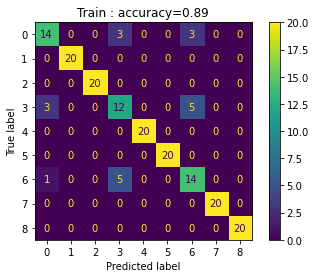

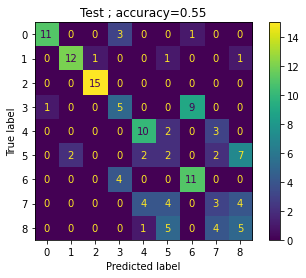

In [18]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(delta, train_acc)
plt.plot(delta, test_acc)
plt.xlabel('delta_om')
plt.ylabel('accuracy')
plt.legend(['train','test'])

### Print les résultats
### Train
train_acc = resultsPs['train_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsPs['train_cm'])
disp.plot()
plt.title(f'Train : accuracy={train_acc:.2f}')

### Test
test_acc = resultsPs['test_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsPs['test_cm'])
disp.plot()
plt.title(f'Test ; accuracy={test_acc:.2f}')

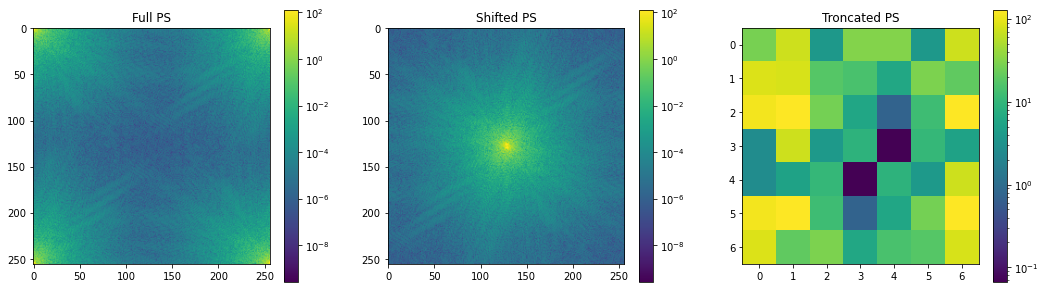

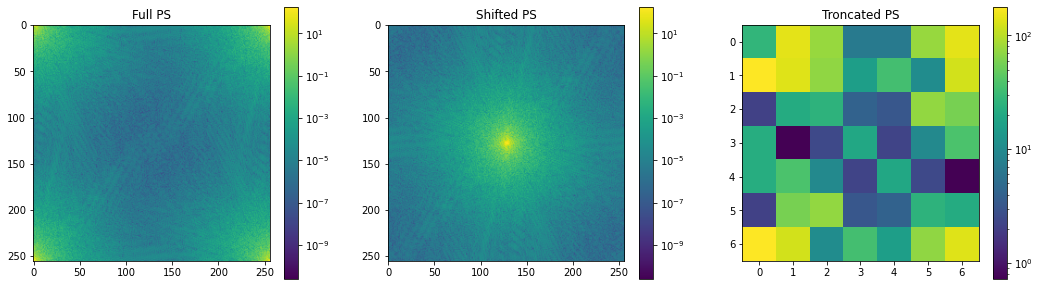

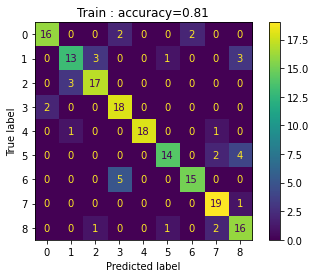

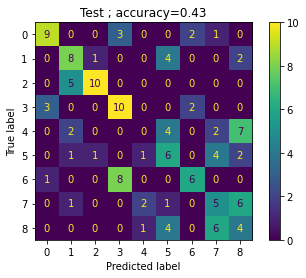

In [19]:
dom = 3
# Calcul les spectres de puissance sur les données Train et Test
psTrain = compute_features_ps(ImgsTrain, dom, NbClasses, NbMapsTrain, SizeMaps)
psTest = compute_features_ps(ImgsTest, dom, NbClasses, NbMapsTest, SizeMaps)

# LDA classification
resultsPs = classify_by_LDA(psTrain, psTest)

### Print les résultats
### Train
train_acc = resultsPs['train_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsPs['train_cm'])
disp.plot()
plt.title(f'Train : accuracy={train_acc:.2f}')

### Test
test_acc = resultsPs['test_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsPs['test_cm'])
disp.plot()
plt.title(f'Test ; accuracy={test_acc:.2f}')
plt.show()

**3.4 TODO :** Commenter ces résultats.

## Analyse des performances et conclusion 

Le but de cette section est de comparer les trois classifications LDA réalisées ci-dessus en terme de performances :
- Quelle méthode obtient les meilleurs résultats ?
- Quelle est celle qui a les plus grandes erreurs ?
- Comment l'erreur est-elle reliée à la variance des features choisis ?

Pour aider à répondre à ces questions, on définit la fonction plot suivante :

In [20]:
def plot_mean_per_class(results:dict, dataT: dict, NbMaps: int, title: str, log_yscale: bool):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title)  
    ymax = max(list(map(np.max, dataT.values())))
    ymin = min(list(map(np.min, dataT.values())))
    for i in range(NbClasses):            
        plt.subplot(3, 3, i+1)
        for j in range(NbMaps):
            features = dataT[i][j,...].reshape(-1)
            plt.plot(features, color='b', alpha=.3)

        plt.plot(results['lda'].means_[i], color='r')
        plt.title(f'Class {i}')
        plt.ylim([ymin, ymax])
        plt.yscale('log') if log_yscale else None
    plt.show()

    fig = plt.figure(figsize=(18,6))
    fig.suptitle(title)  
    for i in range(NbClasses):         
        errors = dataT[i].std(axis=0).reshape(-1)
        plt.errorbar(x=range(len(results['lda'].means_[i])), y=results['lda'].means_[i], yerr=errors, label='class {:}'.format(i))

    plt.ylim([ymin, ymax])
    plt.legend()
    plt.show()
        
    return

**4.1 TODO :** Conclure sur les performances de la LDA sur ces trois choix de features.

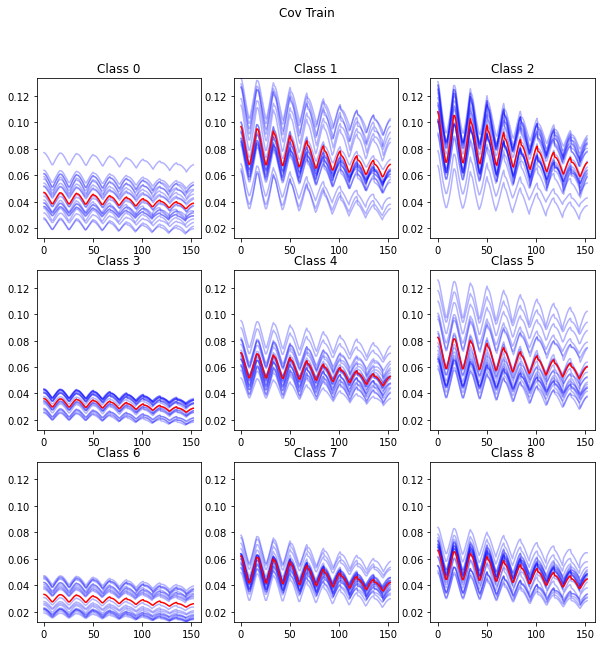

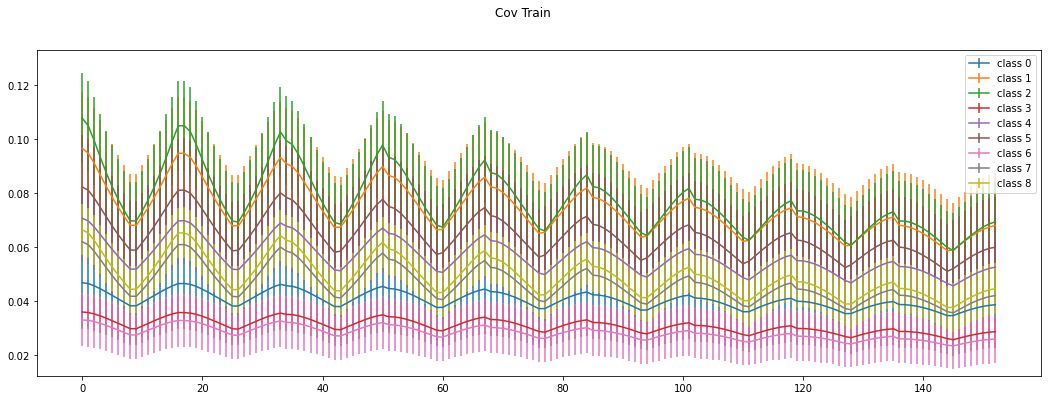

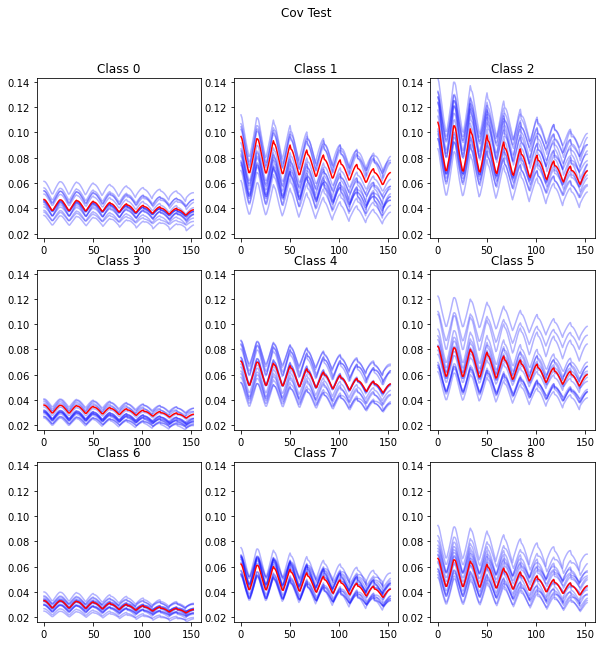

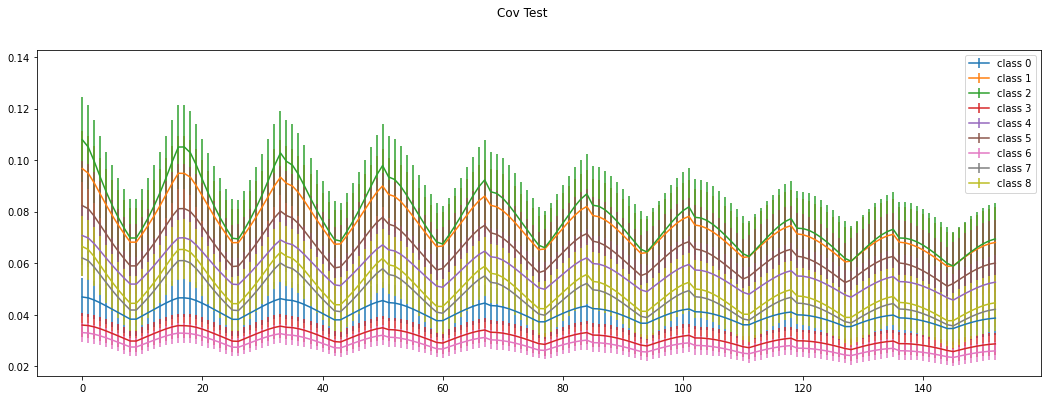

In [21]:
# Plot pour l'autocorrélation
plot_mean_per_class(resultsCov, covTrain, NbMapsTrain, 'Cov Train', False)
plot_mean_per_class(resultsCov, covTest, NbMapsTest, 'Cov Test', False)

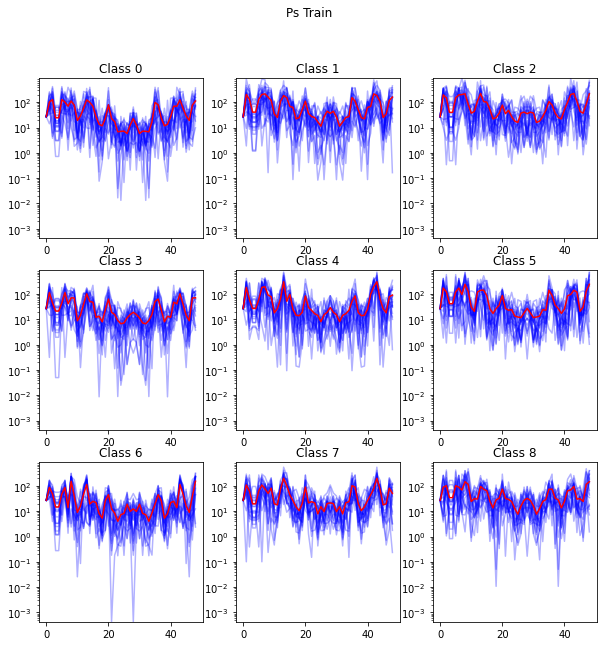

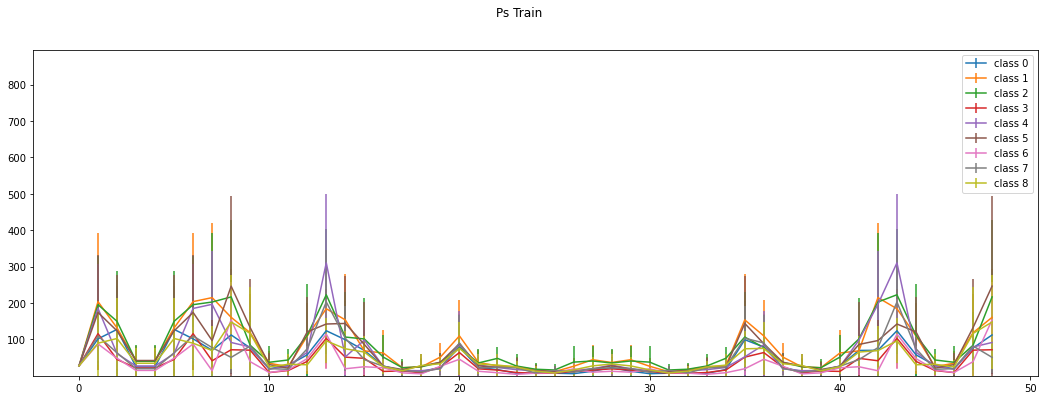

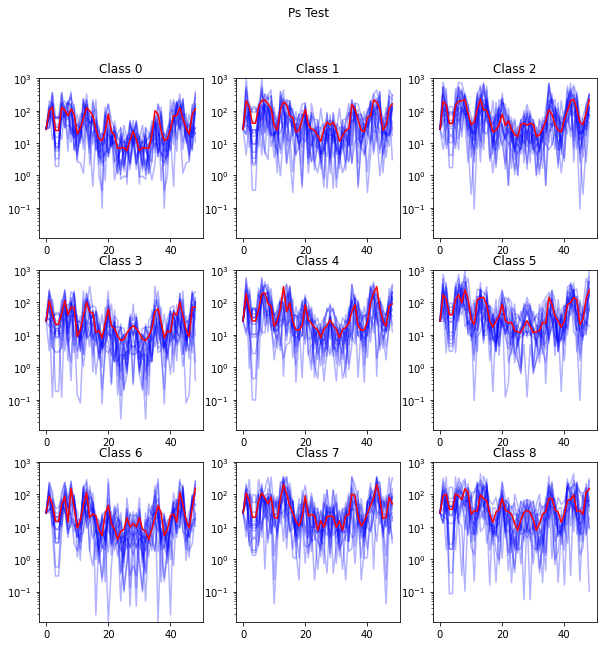

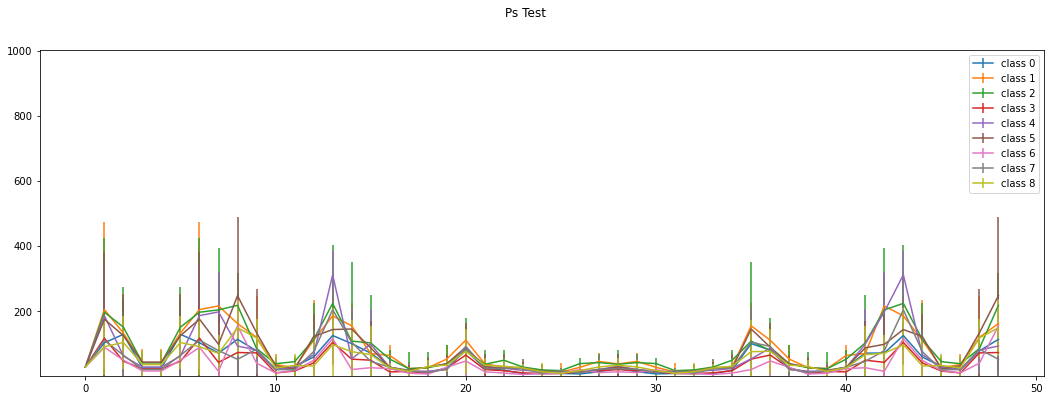

In [22]:
# Plot pour le spectre de puissance
plot_mean_per_class(resultsPs, psTrain, NbMapsTrain, 'Ps Train', True)
plot_mean_per_class(resultsPs, psTest, NbMapsTest, 'Ps Test', True)

On voit beaucoup de régularités dans les covariances estimées, cela incite à les exploiter pour avoir des features de plus basse dimension estimés avec moins de variance. 

**4.2 TODO :** Quelle invariance de groupe n'a pas été exploitée dans la construction des deux derniers features ?

Le groupe des rotations. On a donc intérêt à construire des features isotropes, plus compressés et de variance plus faible.

**4.3 TODO :** En se basant sur les analyses précédentes et une exploration complémentaire, proposer une feature compressée avec une bonne accuracy. 

*Cette question est plus ouverte que les autres. Il n'est pas attendu une feature en particulier, mais des choix d'exploration motivés. La mise en application des concepts étudiés dans le cours, la prise en compte des résultats obtenus précédemment, l'effort de recherche et les illustrations seront valorisés.*

Afin d'exploiter l'invariance par rotation, on va déveloper une verison isotropique du spectre de puissance. On utilise la fonction `isotropic_powspec` dans `utils.py`.

In [23]:
from utils import isotropic_powspec

C'est toujours un bon réflexe d'afficher le feature de base sur quelques exemples afin de comprendre s'il faut éventuellement le scaler et/ou le compresser. 

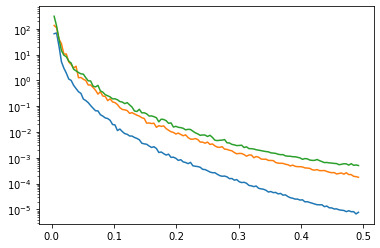

In [24]:
plt.semilogy(*isotropic_powspec(ImgsTrain[0][0]))
plt.semilogy(*isotropic_powspec(ImgsTrain[1][0]))
plt.semilogy(*isotropic_powspec(ImgsTrain[2][0]))
plt.show()

On voit un comportement régulier quand on prend le log du spectre de puissance isotropique. On va donc le scaler ainsi. On voit que les plus petites échelles (à droite) sont plus discriminatives que les grandes échelles (à gauche). C'est d'ailleurs cohérent avec nos observations précédentes : la covariance entre pixels proches ($dn\leq 8 \,\text{pix}$), soit une caractérisation des petites échelles des processus, a obtenu de bien meilleurs résultats que le spectre de puissance tronqué aux basses fréquences ($dom \leq \sim 10 \,\text{pix}^{-1}$), qui correspond quant à lui à une caractérisation des grandes échelles des processus étudiés.

La dimension de ce spectre brut (non tronqué) est élevée: $\sim 120$. On va donc binner le spectre le long des fréquences (un test montre que c'est en effet bénéfique pour l'apprentissage). Un essai de bin logarithmique sur les fréquences ne donne pas de meilleurs résultats qu'un bin linéaire. Cela est cohérent avec notre observation selon laquelle les petites échelles sont plus discriminantes. En effet un binnage logarithmique des fréquences donnera moins de poids aux petites échelles, *i.e.* grandes fréquences, qui seront groupées en des bins plus larges que dans le cas linéaire, ce qui fait donc moins de bins dédiés aux petites échelles.

In [25]:
def compute_features_isotropic_binned_log_ps(Imgs: dict, NbClasses: int) -> dict:
    psmat_cls = {}

    for i in range(NbClasses):
        psmat_cls[i] = np.array([np.log(isotropic_powspec(mp)[1]).reshape((7, 18)).mean(axis=-1) for mp in Imgs[i]])

    return psmat_cls

Text(0.5, 1.0, 'Test ; accuracy=0.81')

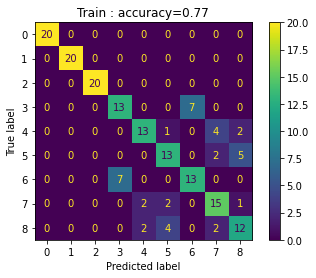

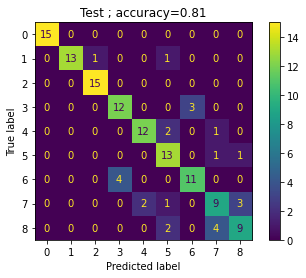

In [26]:
# Calcul les log spectres de puissance isotropes et compressés sur les données Train et Test
psTrain = compute_features_isotropic_binned_log_ps(ImgsTrain, NbClasses)
psTest = compute_features_isotropic_binned_log_ps(ImgsTest, NbClasses)

# LDA classification
resultsPs = classify_by_LDA(psTrain, psTest)

### Print les résultats
### Train
train_acc = resultsPs['train_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsPs['train_cm'])
disp.plot()
plt.title(f'Train : accuracy={train_acc:.2f}')

### Test
test_acc = resultsPs['test_acc']
disp = sklearn.metrics.ConfusionMatrixDisplay(resultsPs['test_cm'])
disp.plot()
plt.title(f'Test ; accuracy={test_acc:.2f}')

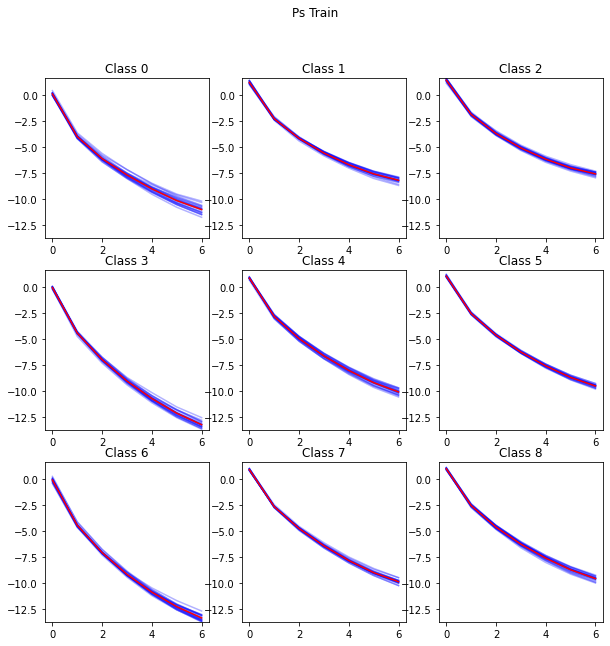

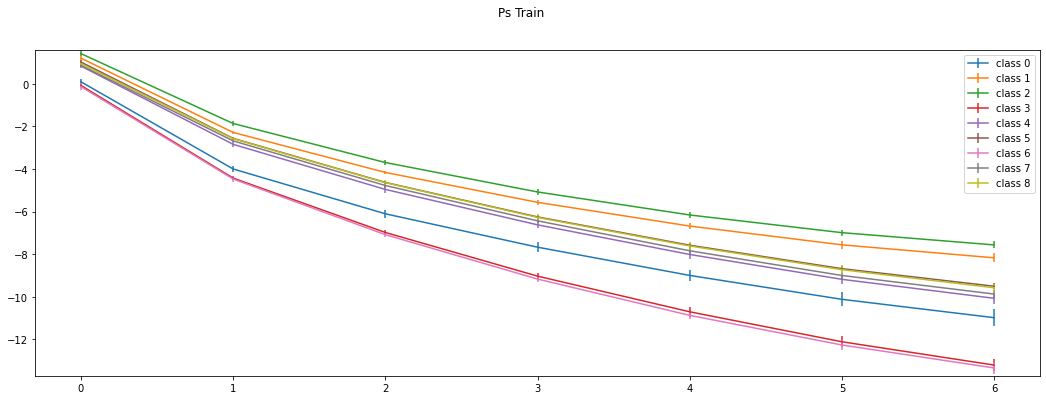

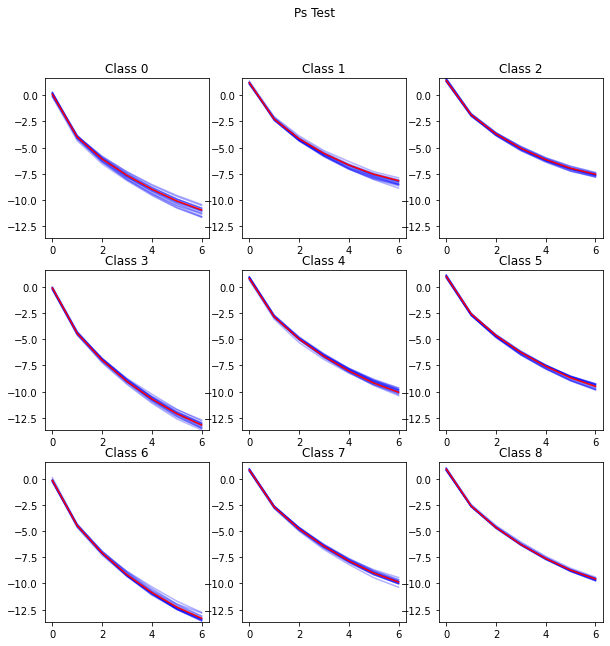

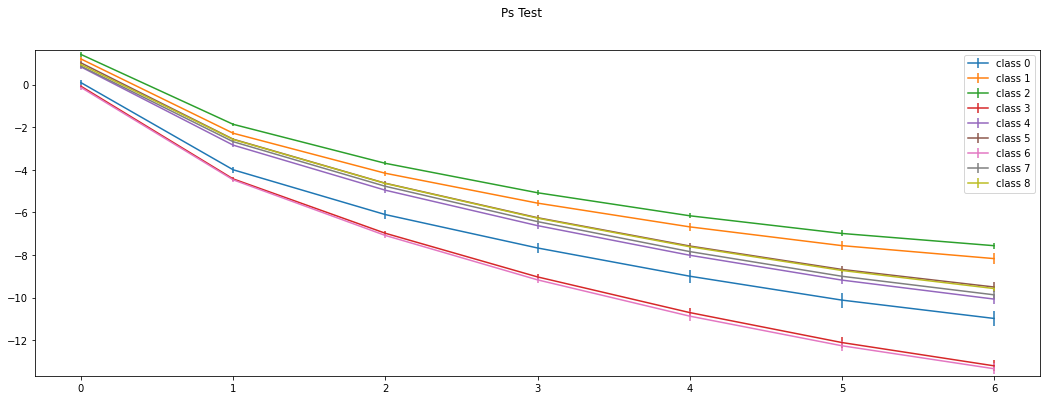

In [27]:
# Plot pour le spectre de log puissance isotropique compressé
plot_mean_per_class(resultsPs, psTrain, NbMapsTrain, 'Ps Train', False)
plot_mean_per_class(resultsPs, psTest, NbMapsTest, 'Ps Test', False)